## Applying Machine Learning To a Facebook Sentiment Analysis

### Obtaining the NH Brewery Facebook post data set

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#### Reading the CVS file

In [2]:
df = pd.read_csv('data.csv', encoding='utf-8')
df.head(5)

,message,sentiment,interactionRate
0,Nantucket Dubbed ‘Best Island In The World’ By...,1,9.8888
1,We will be pouring at this fine event this Sat...,1,0.5203
2,We will be pouring at this fine event this Sat...,0,0.2081
3,We will be pouring at this fine event this Sat...,0,0.0000
4,We're brewing 155 gallons of coffee for our co...,0,0.1635


The attributes have the following meaning:
* **message**: the Facebook post posted by a business in the NH beer industry.
* **sentiment**: looking at if a post is of high engagement or low engagement, 0 is low, 1 is high.
* **interactionRate**: uses the equation ((likes+comments+shares)/(# of posts))*(1/(# of fans))

### Data set with more attributes
Currently causes errros in the fitting of the model but all attributes are incorportated with the interactionRate equation

In [3]:
df2 = pd.read_csv('data2.csv')
df2.head(5)

,message,sentiment,interactionRate,pageName,likes,comments,shares,type,createTime
0,Nantucket Dubbed ‘Best Island In The World’ By...,1,9.8888,Cisco Brewers Nantucket,1473,85,390,Link,02/29/2016 21:41:30
1,We will be pouring at this fine event this Sat...,1,0.5203,Independent Fermentations Brewing,5,0,0,Link,02/29/2016 21:35:55
2,We will be pouring at this fine event this Sat...,0,0.2081,Independent Fermentations Brewing,2,0,0,Link,02/29/2016 21:35:19
3,We will be pouring at this fine event this Sat...,0,0.0000,Independent Fermentations Brewing,0,0,0,Link,02/29/2016 21:34:45
4,We're brewing 155 gallons of coffee for our co...,0,0.1635,Mystic Brewery,8,0,0,Photo,02/29/2016 21:25:15


The attributes have the following meaning:
* **message**: the Facebook post posted by a business in the NH beer industry.
* **sentiment**: looking at if a post is of high engagement or low engagement, 0 is low, 1 is high.
* **interactionRate**: uses the equation ((likes+comments+shares)/(# of posts))*(1/(# of fans))
* **pageName**: business name
* **likes**: message likes
* **comments**: message comments
* **shares**: message shares
* **type**: message type: Link, Photo, Status Update
* **createTime**: date and time meassage was created

## Discover and visualize the data to gain insights

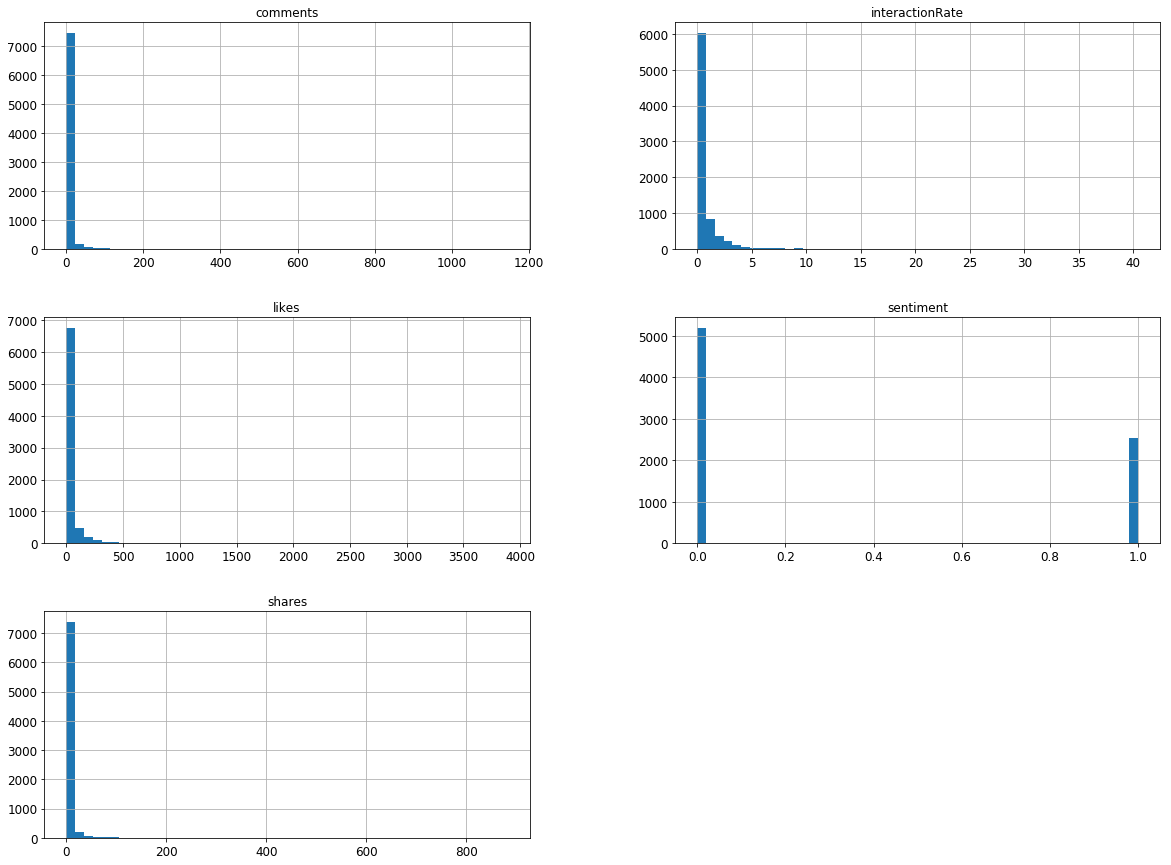

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
df2.hist(bins=50, figsize=(20,15))
plt.show()

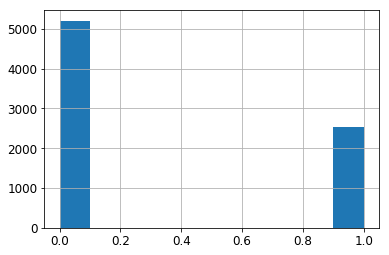

In [5]:
df2["sentiment"].hist()

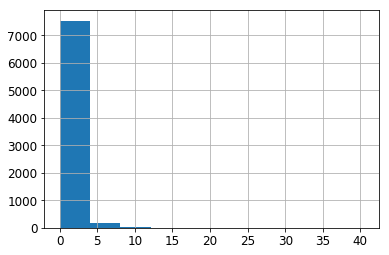

In [6]:
df2["interactionRate"].hist()

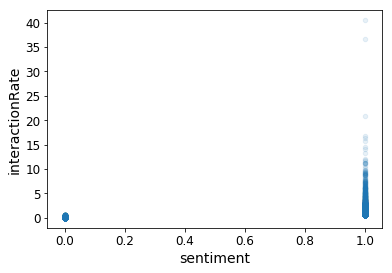

In [7]:
df2.plot(kind="scatter", x="sentiment", y="interactionRate", alpha=0.1)

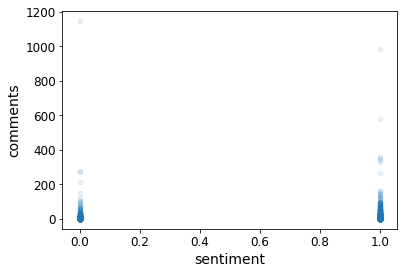

In [8]:
df2.plot(kind="scatter", x="sentiment", y="comments", alpha=0.1)

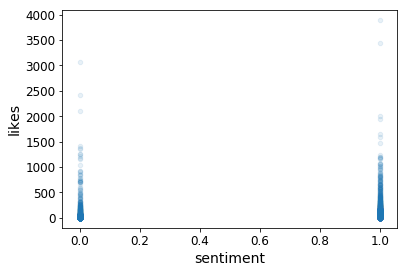

In [9]:
df2.plot(kind="scatter", x="sentiment", y="likes", alpha=0.1)

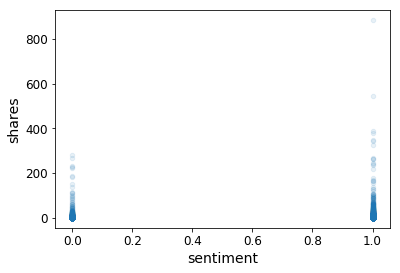

In [10]:
df2.plot(kind="scatter", x="sentiment", y="shares", alpha=0.1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d4aaa20>,
      dtype=object)

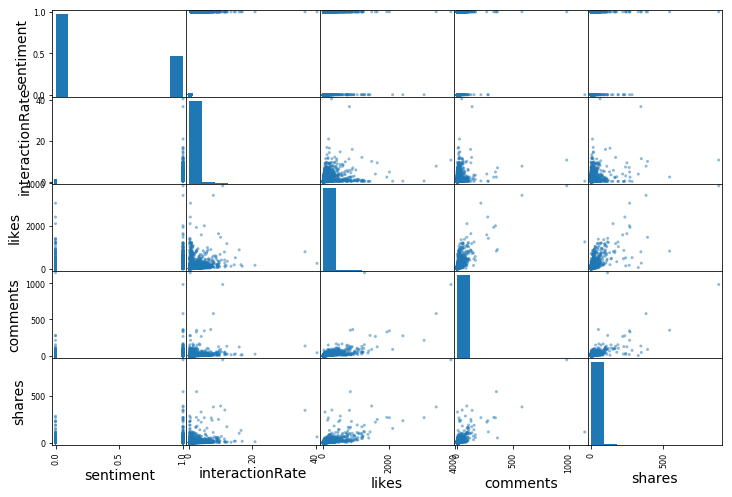

In [11]:
attributes = ["sentiment", "interactionRate", "likes", "comments", 'shares']
scatter_matrix(df2[attributes], figsize=(12, 8))

[0, 16, 0, 20]

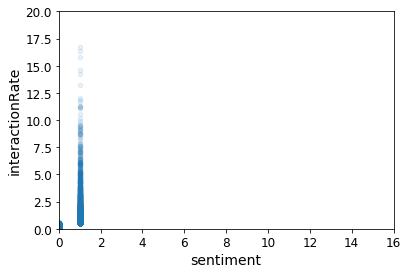

In [12]:
df2.plot(kind="scatter", x="sentiment", y="interactionRate",
             alpha=0.1)
plt.axis([0, 16, 0, 20])

[0, 16, 0, 20]

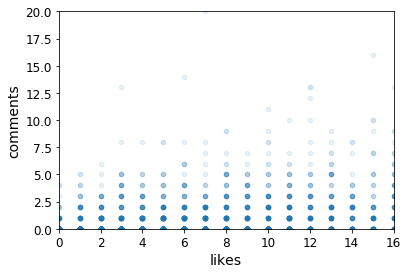

In [13]:
df2.plot(kind="scatter", x="likes", y="comments",
             alpha=0.1)
plt.axis([0, 16, 0, 20])

[0, 16, 0, 20]

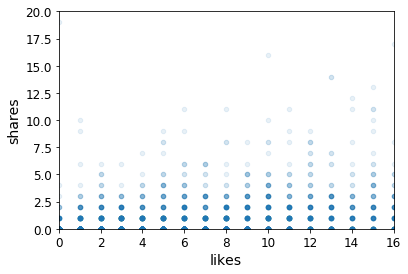

In [14]:
df2.plot(kind="scatter", x="likes", y="shares",
             alpha=0.1)
plt.axis([0, 16, 0, 20])

#### Understanding at the data, looking for null values and value counts

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7737 entries, 0 to 7736
Data columns (total 3 columns):
message            6736 non-null object
sentiment          7737 non-null int64
interactionRate    7733 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 181.4+ KB


In [16]:
df.describe()

,sentiment,interactionRate
count,7737.000000,7733.000000
mean,0.327776,0.692752
std,0.469433,1.404854
min,0.000000,0.000000
25%,0.000000,0.072000
50%,0.000000,0.241500
75%,1.000000,0.702000
max,1.000000,40.462400


In [17]:
df["sentiment"].value_counts()

0    5201
1    2536
Name: sentiment, dtype: int64

### bag-of-words model

Transforming documents into feature vectors and assessing word relevancy via term frequency-inverse document frequency

In [18]:
vectorizer = CountVectorizer()
np.set_printoptions(precision=2)

In [19]:
vectorizer.fit_transform(df['message'].values.astype('U'))

<7737x14756 sparse matrix of type '<class 'numpy.int64'>'
	with 183162 stored elements in Compressed Sparse Row format>

In [20]:
tfidf = TfidfTransformer(use_idf=True, 
                         norm='l2', 
                         smooth_idf=True)

### Processing documents into tokens by whitespace

In [21]:
porter = PorterStemmer()
def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

#### Removing stop words

In [22]:
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bridgetfranciscovich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Breaking the data into test and train data sets

In [23]:
X_train = df.iloc[:6000, 0].values.astype('U')
y_train = df.iloc[:6000, 1].values
X_test = df.iloc[6000:, 0].values.astype('U')
y_test = df.iloc[6000:, 1].values

### Training the model and creating a pipeline using Logistic Regression

In [24]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None, decode_error='replace', encoding='utf-8')

In [25]:
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__stop_words': [stop, None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

In [26]:
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

In [27]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=2,
                           verbose=1)

#### Filling in the blank pieces training of data
Fixes ValueError: np.nan is an invalid document, expected byte or unicode string.

In [28]:
X_train = tfidf.fit_transform(df['message'].values.astype('U'))
X_train, y_train = df.message.fillna(' '), df.sentiment

#### Fitting the model

In [29]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.0min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='replace',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__tokenizer': [<function tokenizer at 0x1a1263f0d0>, <function tokenizer_porter at 0x1a20096b70>], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yours... "won't", 'wouldn', "wouldn't"], None], 'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [30]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x1a20096b70>} 
CV Accuracy: 0.705


In [31]:
clf = gs_lr_tfidf.best_estimator_
clf.predict(X_test)

array([0, 1, 0, ..., 0, 0, 1])

#### Filling in the blank pieces training of data

In [32]:
X_train, y_train = df.message.fillna(' '), df.sentiment

### Testing the model's accuracy

In [33]:
clf.predict(X_test)

array([0, 1, 0, ..., 0, 0, 1])

In [34]:
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.784


In [35]:
example = ['Nantucket', 'We are donating to the troops for every sale we make!', 'Try our new Sassion beer with an ABV 3.4%', 'Our new IPA is hoppy and on tap!']
clf.predict(example)

array([0, 0, 0, 0])

### Breaking the data into test and train data sets

In [66]:
X_train = df.iloc[:6000, 0].values
y_train = df.iloc[:6000, 1].values
X_test = df.iloc[6000:, 0].values
y_test = df.iloc[6000:, 1].values

### Training the model and creating a pipeline using Stochastic Gradient Descent

In [67]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

In [68]:
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__stop_words': [stop, None]},
              ]

In [69]:
lr_tfidf = Pipeline([('vect', tfidf),
                    ('sgd', SGDClassifier(random_state=0))]) #, loss='log'

In [70]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1)

#### Filling in the blank pieces training of data
Fixes ValueError: np.nan is an invalid document, expected byte or unicode string.

In [71]:
X_train, y_train = df.message.fillna(' '), df.sentiment

#### Fitting the model

In [72]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/bridgetfranciscovich/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/bridgetfranciscovich/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

/Users/bridgetfranciscovich/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/bridgetfranciscovich/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...lty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__tokenizer': [<function tokenizer at 0x1a1263f0d0>, <function tokenizer_porter at 0x1a20096b70>], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yours...', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"], None]}],
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [73]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x1a1263f0d0>} 
CV Accuracy: 0.708


In [74]:
clf = gs_lr_tfidf.best_estimator_

In [76]:
#clf.predict(X_test)

#### Filling in the blank pieces testing of data

In [77]:
X_test, y_test = df.message.fillna(' '), df.sentiment

### Testing the model's accuracy

In [78]:
clf.predict(X_test)

array([1, 0, 0, ..., 0, 0, 1])

In [79]:
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.906


In [80]:
example = ['Nantucket', 'We are donating to the troops for every sale we make!', 'Try our new Sassion beer with an ABV 3.4%', 'Our new IPA is hoppy and on tap!']
clf.predict(example)

array([1, 0, 1, 1])

## Pickle the model

In [81]:
list_pickle_path = 'fb_pickle.pkl'

In [82]:
pickle.dump(clf, open(list_pickle_path, 'wb'))